# Advanced Time Series Econometrics
## Lorenzo Mezzini - 926012

In [1]:
import numpy as np 
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random

## 1) Generation of the data sample

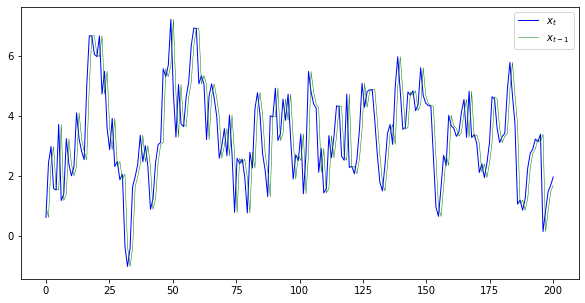

In [2]:
# global variables
delta_0, rho_0, sq_0, T, x_0, B = [1, 0.7, 1, 200, 1, 399]

# Generation of Data sample
x = [x_0]
e_t = stats.norm.rvs(loc=0, scale = sq_0, size = T, random_state = 123)

for i in range(T):
    x.append(delta_0 + rho_0 * x[-1] + e_t[i])

# Plot
fig = plt.figure(figsize = (10,5))
plt.plot(np.linspace(0,T,T), x[1:], color = 'b',linewidth = 1, label = '$x_t$')
plt.plot(np.linspace(0,T,T), x[:-1], color = 'g',linewidth = .5, label = '$x_{t-1}$' )
plt.legend()
plt.show()

### Now I compute the MLE estimators for both the restricted and unrestricted model

In [3]:
# this calculate the  - Log likehood, since with scipy.optimise I can only minimize.
def log_likehood(theta, xt, xt2):
    errors = [theta[0] + theta[1]*i for i in xt2]
    return 0.5 * ((len(xt)-1)* np.log(theta[2]) + sum([(i-j)**2 for i , j in zip(xt, errors)])/theta[2])

theta0 = [0.5,0.5,0.5] # a random guess
bounds_un = ((None,None),(None,None), (1.e-10, None)) # Boundaries of research for the unresticted model
bounds_re = ((None,None),(0.7,0.7), (1.e-10, None)) # Resticted model boundaries

llik_un = minimize(log_likehood, theta0, args = (x[1:],x[:-1]), bounds=bounds_un) #calc log likehood unresticted
llik_re = minimize(log_likehood, theta0, args = (x[1:],x[:-1]), bounds=bounds_re) #calc log likehood resticted

# LR is inverted since the signs of the log likehoods is inverted
LR = 2*(llik_re.fun - llik_un.fun)

print("MLE unrestricted estimaor : \n\n" + 
    "\tDelta : \t" + str(np.round(llik_un.x[0], decimals = 3)) + "\n"+
    "\tRho : \t\t" + str(np.round(llik_un.x[1], decimals = 3)) + "\n"+
    "\tSigma2 : \t" + str(np.round(llik_un.x[2], decimals = 3)) + "\n\n" + 
    "MLE restricted estimator : \n\n" + 
    "\tDelta : \t" + str(np.round(llik_re.x[0], decimals = 3)) + "\n"+
    "\tRho : \t\t" + str(np.round(llik_re.x[1], decimals = 3)) + "\n"+
    "\tSigma2 : \t" + str(np.round(llik_re.x[2], decimals = 3)) + "\n\n" + 
    "Likehood ratio: \t" + str(np.round(LR,decimals=4)) + "\n" +
    "p-value: \t\t" + str(np.round(1 - stats.chi.cdf(LR,1), decimals=4)))

MLE unrestricted estimaor : 

	Delta : 	0.952
	Rho : 		0.715
	Sigma2 : 	1.113

MLE restricted estimator : 

	Delta : 	1.004
	Rho : 		0.7
	Sigma2 : 	1.113

Likehood ratio: 	0.0985
p-value: 		0.9215


### Now I save both the errors and the centered errors

In [4]:
e_hat = [i - llik_un.x[1] * j - llik_un.x[0]  for i, j in zip(x[1:], x[:-1])] 
e_tilde = [i - llik_re.x[0] * j - llik_re.x[0] for i, j in zip(x[1:], x[:-1])]

m1 = sum(e_hat)/len(e_hat)
m2 = sum(e_tilde)/len(e_tilde)
e_hat_c = [i - m1 for i in e_hat] 
e_tilde_c = [i - m2 for i in e_tilde]

## 2-3-4) Bootstrap implementation

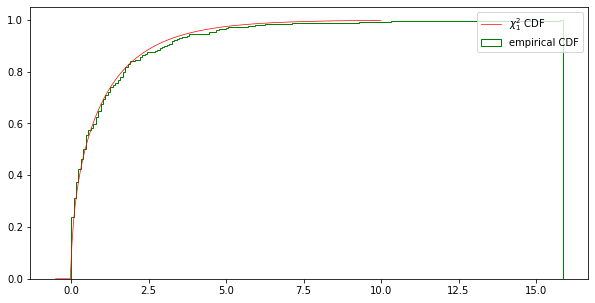

In [5]:
LikehoodRatio_bootstrap = []
for i in range(B):

    # Creation of the Fixed regression bootstrap
    x_bs = [llik_un.x[0] + llik_un.x[1] * i + j for i, j in zip(x[:-1], random.choices(e_hat_c, k = len(e_hat_c)))]

    llik_bs_un = minimize(log_likehood, theta0, args = (x_bs, x[:-1]), bounds=bounds_un)
    llik_bs_re = minimize(log_likehood, theta0, args = (x_bs, x[:-1]), bounds=bounds_re)

    LikehoodRatio_bootstrap.append(2*(llik_bs_re.fun - llik_bs_un.fun))

# Plot
x_axys = np.linspace(-0.5,10,200)
y_cdf = stats.chi2.cdf(x_axys,1) 
fig = plt.figure(figsize = (10,5))
plt.hist(LikehoodRatio_bootstrap, density=True, cumulative = True, bins = 200, color='g',histtype='step', label = 'empirical CDF')
plt.plot(x_axys, y_cdf, linewidth = .7, color = 'r', label = '$\chi^2_1$ CDF')
plt.legend()
plt.show()


We can see that the LR converges to a $\chi^2_1$, this strenghen the initial result obtained and we can accept the null hypotesis of $H_0 : \rho = 0.7$



## 5) Comparison with $\rho_0 = 1$

With the wrong $H_0$ the test statistic shouldn't converge to the $\chi^2_1$ anymore. It could be proved algebraically, but we can see it empirically by computing the exercise above again with the new restiction.

In additoin the sequence with $\rho_0 = 1$ is not stationary.

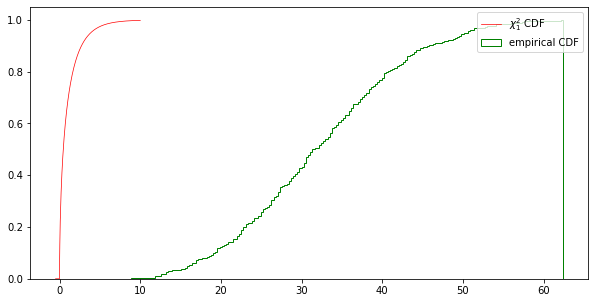

In [6]:
LikehoodRatio_bootstrap_1 = []
bounds_re_1 = ((None,None),(1,1), (1.e-10, None)) # New bounds for rho_0 = 1
for i in range(B):

    # Creation of the Fixed regression bootstrap
    x_bs = [llik_un.x[0] + llik_un.x[1] * i + j for i, j in zip(x[:-1], random.choices(e_hat_c, k = len(e_hat_c)))]

    llik_bs_un = minimize(log_likehood, theta0, args = (x_bs, x[:-1]), bounds=bounds_un)
    llik_bs_re = minimize(log_likehood, theta0, args = (x_bs, x[:-1]), bounds=bounds_re_1) # new boundaries 

    LikehoodRatio_bootstrap_1.append(2*(llik_bs_re.fun - llik_bs_un.fun))

# Plot
fig = plt.figure(figsize = (10,5))
plt.hist(LikehoodRatio_bootstrap_1, density=True, cumulative = True, bins = 200, color='g',histtype='step', label = 'empirical CDF')
plt.plot(x_axys, y_cdf, linewidth = .7, color = 'r', label = '$\chi^2_1$ CDF')
plt.legend()
plt.show()
